In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import extract
import visualize
from sklearn import tree
import pydotplus
import seaborn as sns

In [245]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [246]:
d = extract.get_data()
d = extract.clean_data(d)

In [247]:
d.head()

,tradeid,cusip,amount,price,yield,tradedate,tradetype,name,state,coupon,maturity,issuesize,issuetype,issuesource,bidcount,rtg
0,317.0,45471AKG6,5000.0,99.507,4.037,0.0,Sale_to_Customer,indiana st fin auth-a,Indiana,4.00,6635.0,88930000.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",NaN,6
1,318.0,45471AKG6,30000.0,99.410,4.045,0.0,Sale_to_Customer,indiana st fin auth-a,Indiana,4.00,6635.0,88930000.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",NaN,6
2,319.0,45471AKG6,30000.0,99.290,4.054,0.0,Purchase_from_Customer,indiana st fin auth-a,Indiana,4.00,6635.0,88930000.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",NaN,6
3,333.0,45471AMY5,15000.0,103.145,3.717,0.0,Sale_to_Customer,in fin auth-major,Indiana,4.25,6423.0,9520000.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",NaN,9
4,378.0,4550572N8,150000.0,114.082,2.060,0.0,Sale_to_Customer,in fin auth-ref-a,Indiana,5.00,2894.0,22530000.0,REVENUE BONDS,WATER REVENUE,NaN,1


In [248]:
s0 = pd.read_csv("./data/price_change_data.csv", usecols = ['d_index', 'tradetype',
		'state', 'coupon', 'maturity', 'issuetype', 'issuesource', 'rtg',
		'tradedate', 'dprice', 'holdtime'])

In [249]:
s0[:10]

,tradedate,tradetype,state,coupon,maturity,issuetype,issuesource,rtg,dprice,holdtime,d_index
0,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,-0.762,1.0,0
1,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,0.376,1.0,0
2,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,0.473,6.0,0
3,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,1.614,8.0,0
4,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,1.272,10.0,0
5,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,-0.211,21.0,0
6,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,0.126,21.0,0
7,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,-0.306,27.0,0
8,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,-2.240,29.0,0
9,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,-0.665,1.0,1


In [250]:
d_index = s0.pop('d_index')
s_state_features = extract.build_state_features(s0, num_states = None)
s_other_features = extract.build_other_text_features(s0)
s = pd.concat([s0.drop(['state', 'issuetype', 'issuesource', 'tradetype'], axis = 1), s_state_features, s_other_features], axis = 1)
s = s.dropna()
s = s[s.holdtime < 7] #pick out only data with holdtime < 7 days

In [251]:
s.head()

,tradedate,coupon,maturity,rtg,dprice,holdtime,Alabama,Alaska,Arizona,Arkansas,...,SPECIAL ASSESSMENT,SPECIAL TAX,STUDENT LOAN REVENUE,TAX INCRMT./ALLCTN.REV.,TELECOM REVENUE,TOBACCO & LIQUOR TAXES,TOBACCO SETTLEMENT FUNDED,TRANSIT REVENUE,WATER REVENUE,tradetype
0,0.0,4.0,6635.0,6,-0.762,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.0,4.0,6635.0,6,0.376,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.0,4.0,6635.0,6,0.473,6.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0.0,4.0,6635.0,6,-0.665,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10,0.0,4.0,6635.0,6,0.473,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Try a Random Forest Regressor

In [252]:
dprice = s.pop('dprice')

In [253]:
s_train, s_test, dp_train, dp_test = train_test_split(s, dprice, test_size=0.20, random_state=180)

### Want to optimize the max_depth and n_estimators parameters of the regressor with respect to the percentage of winning predictions that are actually winners. To do this, we construct a custom scorer function

In [254]:
def scorer(clf, X_test, y_test):
    #we want to maximize the recall of positive gains, i.e. the estimator catches the most positive outcomes
    y_predict = clf.predict(X_test)
    return float(np.sum(y_predict[y_test > 0] > 0))/np.sum(y_test > 0)

In [255]:
parameters = {'max_depth':[10, 15, 20, 25], 'n_estimators':[50, 100, 200], 'criterion':['mse']}
rfr = RandomForestRegressor()
clf = GridSearchCV(rfr, param_grid = parameters, scoring = scorer)

In [256]:
clf.fit(s_train, dp_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 200], 'criterion': ['mse'], 'max_depth': [10, 15, 20, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x7f180c3cd410>, verbose=0)

In [257]:
clf.cv_results_
estimator = clf.best_estimator_
clf.best_params_

{'criterion': 'mse', 'max_depth': 25, 'n_estimators': 100}

In [258]:
dp_predict = estimator.predict(s_test)

In [259]:
dp_predict[:10]

array([-2.53775631, -3.14211369, -0.51105701, -2.69463894,  0.6119329 ,
        0.0874613 , -2.44607662, -1.09169946, -1.33070007, -0.76649239])

In [260]:
dp_test[:10]

6134    -2.545
76299   -3.211
23792   -0.831
53333   -2.850
73692    0.640
70469    0.355
61604   -2.575
61767   -0.729
74650   -1.092
43275   -1.373
Name: dprice, dtype: float64

In [261]:
I1 = dp_test > 0
np.sum(I1)
#scorer(estimator, s_test, dp_test)

593

### below: of the actual test cases where price increased, which fraction were predicted by the model to be an increase?

In [262]:
float(np.sum(dp_predict[I1] > 0))/np.sum(I1)

0.3102866779089376

In [263]:
I2 = (dp_test > 0) & (dp_predict > 0)
np.sum(I2)

184

### below: percentage of samples that were predicted by model to be increase and were actually an increase.

In [264]:
float(np.sum(I2))/np.sum(dp_predict > 0)

0.7131782945736435

### below: percentage of total predictions correct

In [265]:
float(np.sum((dp_predict>0) == (dp_test>0)))/dp_test.size

0.9084360189573459

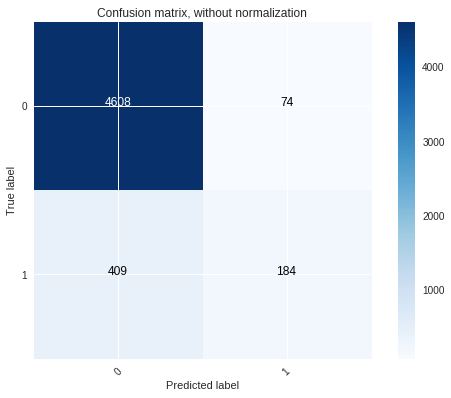

In [266]:
cnf_matrix = confusion_matrix((dp_test>0).astype(np.int), (dp_predict>0).astype(np.int))
plt.figure()
visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Confusion matrix, without normalization')
plt.show()

### For correctly predicted winners, what are typical values of dprice?

0.00299999999999 6.5 0.883402173913


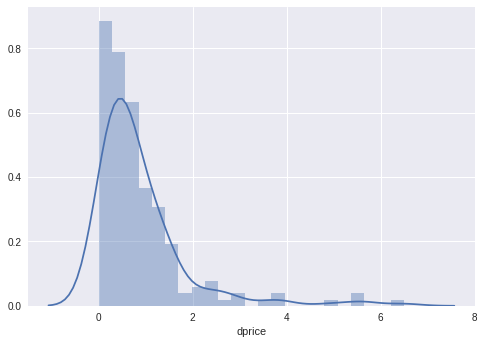

In [267]:
dp_slice = dp_test[I2]
print dp_slice.min(), dp_slice.max(), dp_slice.mean()
sns.distplot(dp_slice)
plt.show()

### Plot distribution of dprice_test when winner is predicted but it's actually a loser

-3.632 -0.00299999999999 -0.913394366197


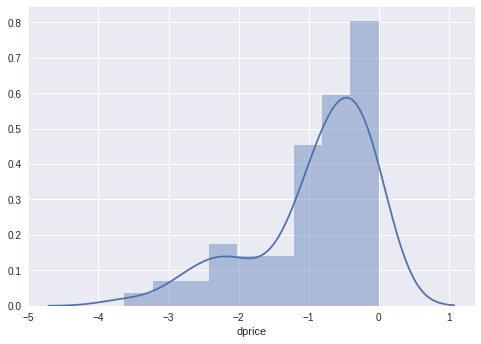

In [268]:
dp_slice_loser = dp_test[(dp_test < 0) & (dp_predict > 0)]
print dp_slice_loser.min(), dp_slice_loser.max(), dp_slice_loser.mean()
sns.distplot(dp_slice_loser)
plt.show()

In [269]:
clf.best_estimator_.feature_importances_

array([  2.06677892e-01,   1.03376350e-01,   2.31205314e-01,
         9.93656658e-02,   1.06924897e-01,   3.65121870e-03,
         2.98461489e-05,   1.60458947e-03,   3.56364438e-05,
         8.80916770e-03,   6.55847242e-03,   2.60601490e-03,
         1.72491081e-04,   7.73250376e-04,   3.12047873e-03,
         1.14228704e-03,   1.64831131e-05,   6.96586671e-04,
         1.98011059e-04,   5.34031203e-03,   7.29535680e-04,
         1.33439107e-04,   4.19549327e-04,   6.63612245e-04,
         1.15119699e-03,   2.02177613e-05,   4.76314622e-03,
         3.01516327e-03,   5.79100614e-04,   3.31709526e-04,
         6.89802977e-05,   1.14274467e-03,   5.74715064e-04,
         6.33670230e-04,   1.78794763e-04,   4.40523810e-03,
         3.40996830e-03,   8.21099777e-03,   9.50827609e-04,
         0.00000000e+00,   1.24462229e-02,   4.78900912e-04,
         9.74235014e-05,   5.92049526e-03,   5.12729218e-03,
         5.63471234e-05,   2.43793745e-03,   0.00000000e+00,
         8.73773361e-04,

In [272]:
important_features_indices = np.where(clf.best_estimator_.feature_importances_ > 0.01)
ordered_indices = sorted(range(s.shape[1]), key=clf.best_estimator_.feature_importances_.__getitem__)
ordered_indices.reverse()
ordered_indices[:20]

[2, 0, 4, 1, 3, 103, 40, 102, 59, 64, 9, 65, 37, 68, 52, 87, 10, 75, 60, 76]

In [273]:
list(s_test.columns[ordered_indices[:20]])

['maturity',
 'tradedate',
 'holdtime',
 'coupon',
 'rtg',
 'TOBACCO SETTLEMENT FUNDED',
 'Ohio',
 'TOBACCO & LIQUOR TAXES',
 'GENERAL OBLIGATION UNLTD',
 'AD VALOREM PROPERTY TAX',
 'California',
 'APPROPRIATIONS',
 'New York',
 'COLLEGE & UNIV. REV.',
 'Virgin Islands',
 'MISCELLANEOUS REVENUE',
 'Colorado',
 'HIGHWAY REVENUE TOLLS',
 'REVENUE BONDS',
 'HLTH, HOSP, NURSHOME REV.']

In [274]:
clf.best_estimator_.feature_importances_[ordered_indices[:20]]

array([ 0.23120531,  0.20667789,  0.1069249 ,  0.10337635,  0.09936567,
        0.01423455,  0.01244622,  0.0118646 ,  0.00964961,  0.00882271,
        0.00880917,  0.00833034,  0.008211  ,  0.00723097,  0.00678431,
        0.00664507,  0.00655847,  0.00648117,  0.00603662,  0.00599456])

### Pick out best estimator and save decision tree to file, using max_depth = 5. Make sure to label features appropriately and set filled = True and feature_names = list(s_test.columns)

In [277]:
#clf_best = clf.best_estimator_
#tree0 = clf_best.estimators_[21]
clf_dec = DecisionTreeRegressor(max_depth = 25, max_features = None, criterion = 'mse')
clf_dec.fit(s_train, dp_train)

DecisionTreeRegressor(criterion='mse', max_depth=25, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

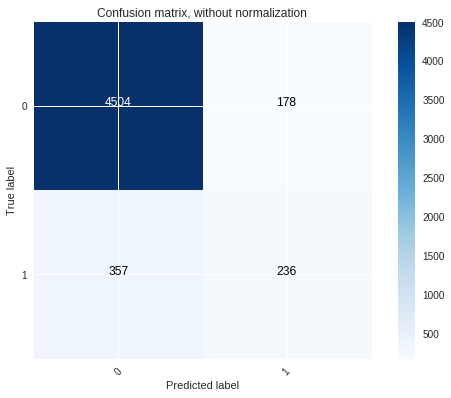

In [278]:
dp_predict_0 = clf_dec.predict(s_test)
cnf_matrix = confusion_matrix((dp_test>0).astype(np.int), (dp_predict_0>0).astype(np.int))
plt.figure()
visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Confusion matrix, without normalization')
plt.show()

In [279]:
tree.export_graphviz(clf_dec, 'dprice_decision_tree.dot', max_depth = 5, filled = True, feature_names = list(s_test.columns))

### To convert to .png, in the terminal type "dot -Tpng dprice_decision_tree_0.dot -o dprice_decision_tree_0.png"